In [1]:
import sys
sys.path.append('../')
from imports import losses,metrics
import tensorflow.keras as keras
import os
import random
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import datetime

import tensorflow
%load_ext tensorboard
import datetime, os

Using TensorFlow backend.


In [2]:
DATA_PATH = '../Data/'
FRAME_PATH = DATA_PATH+'Images/'
MASK_PATH = DATA_PATH+'Masks/'

DATASET_PATH = DATA_PATH + 'Dataset/'

# Create folders to hold images and masks
folders = ['train_frames/train', 'train_masks/train', 
           'val_frames/val', 'val_masks/val', 
           'test_frames/test', 'test_masks/test']

for f in folders:
    pth = DATASET_PATH + f
    if not os.path.exists(pth):
        os.makedirs(pth)

In [3]:
all_frames = os.listdir(FRAME_PATH)
all_masks = os.listdir(MASK_PATH)
random.shuffle(all_frames)


# Generate train, val, and test sets for frames

train_split = int(0.7*len(all_frames))
val_split = int(0.9 * len(all_frames))

train_frames = all_frames[:train_split]
val_frames = all_frames[train_split:val_split]
test_frames = all_frames[val_split:]

# Generate corresponding mask lists for masks

train_masks = [f for f in all_masks if f in train_frames]
val_masks = [f for f in all_masks if f in val_frames]
test_masks = [f for f in all_masks if f in test_frames]

In [4]:
#Add train, val, test frames and masks to relevant folders


def add_frames(dir_name, image): 
    img = Image.open(FRAME_PATH+image)
    img.save(DATASET_PATH+'{}'.format(dir_name)+'/'+image)
    
def add_masks(dir_name, image):
    img = Image.open(MASK_PATH+image)
    img.save(DATASET_PATH+'{}'.format(dir_name)+'/'+image)

    
frame_folders = [(train_frames, 'train_frames/train'), (val_frames, 'val_frames/val'), 
                 (test_frames, 'test_frames/test')]

mask_folders = [(train_masks, 'train_masks/train'), (val_masks, 'val_masks/val'), 
                (test_masks, 'test_masks/test')]

# Add frames

for folder in frame_folders:
    array = folder[0]
    name = [folder[1]] * len(array)

    list(map(add_frames, name, array))
         
    
# Add masks

for folder in mask_folders:
    array = folder[0]
    name = [folder[1]] * len(array)
    list(map(add_masks, name, array))

In [15]:
# Build U-Net model
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [16]:
import cv2
batch_size=4
def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    random.shuffle(n)
  
    while (True):
        img = np.zeros((batch_size, 256, 256, 3)).astype('float')
        mask = np.zeros((batch_size, 256, 256, 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to 16, c = 0. 

            train_img = cv2.imread(img_folder+'/'+n[i])/255.
            train_img =  cv2.resize(train_img, (256, 256))# Read an image from folder and resize
      
            img[i-c] = train_img #add to array - img[0], img[1], and so on.
                                                   

            train_mask = cv2.imread(mask_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
            train_mask = cv2.resize(train_mask, (256, 256))
            train_mask = train_mask.reshape(256, 256, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]

            mask[i-c] = train_mask

        c+=batch_size
        if(c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
                  # print "randomizing again"
        yield img, mask




train_frame_path = DATASET_PATH + 'train_frames/train'
train_mask_path = DATASET_PATH + 'train_masks/train'

val_frame_path = DATASET_PATH + 'val_frames/val'
val_mask_path = DATASET_PATH + 'val_masks/val'

test_frame_path = DATASET_PATH + 'test_frames/test'
test_mask_path = DATASET_PATH + 'test_masks/test'

# Train the model
train_gen = data_gen(train_frame_path,train_mask_path, batch_size = batch_size)
val_gen = data_gen(val_frame_path,val_mask_path, batch_size = batch_size)
test_gen = data_gen(test_frame_path,test_mask_path, batch_size = batch_size)

In [21]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0)

NO_OF_TRAINING_IMAGES = len(os.listdir(DATASET_PATH + 'train_frames/train'))
NO_OF_VAL_IMAGES = len(os.listdir(DATASET_PATH + 'val_frames/val'))

NO_OF_EPOCHS = 20

BATCH_SIZE = batch_size

weights_path = 'weigths'

#opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.iou,metrics.jaccard_coef])

#checkpoint = ModelCheckpoint(weights_path, monitor='binary_crossentropy', 
#                             verbose=1, save_best_only=True, mode='max')

#earlystopping = EarlyStopping(monitor = 'binary_crossentropy', verbose = 1,
#                              min_delta = 0.01, patience = 3, mode = 'max')

callbacks_list = [tensorboard_callback]#csv_logger, tbCallBack]

results = model.fit_generator(train_gen, epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_gen, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                          callbacks=callbacks_list)
model.save('Model.h5')

Epoch 1/20
259/259 [==============================] - 29s 111ms/step - loss: 0.0513 - acc: 0.9806 - iou: 0.9015 - jaccard_coef: 0.9015 - val_loss: 0.0485 - val_acc: 0.9818 - val_iou: 0.9037 - val_jaccard_coef: 0.9037
Epoch 2/20
259/259 [==============================] - 29s 112ms/step - loss: 0.0492 - acc: 0.9813 - iou: 0.9047 - jaccard_coef: 0.9047 - val_loss: 0.0441 - val_acc: 0.9828 - val_iou: 0.9126 - val_jaccard_coef: 0.9126
Epoch 3/20
250/259 [===========================>..] - ETA: 0s - loss: 0.0488 - acc: 0.9813 - iou: 0.9047 - jaccard_coef: 0.9047

KeyboardInterrupt: 

In [8]:
NO_OF_TEST_IMAGES = len(os.listdir(DATASET_PATH + 'test_frames/test'))

evaluated = model.evaluate_generator(test_gen,steps =  NO_OF_TRAINING_IMAGES//BATCH_SIZE)

In [9]:
evaluated

[0.04587117803344165, 0.9823964, 0.9127282, 0.9127283]

In [10]:
predict = model.predict_generator(test_gen,steps =  NO_OF_TRAINING_IMAGES//BATCH_SIZE)

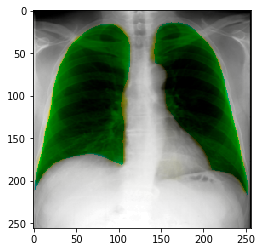

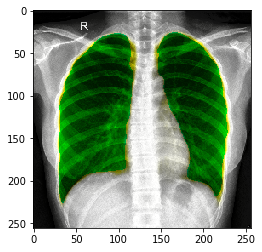

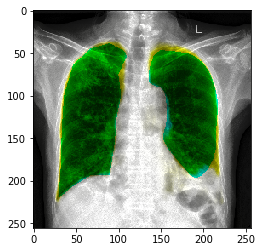

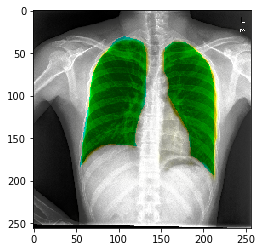

In [11]:
batch = next(test_gen)
images, masks = batch
for i in range(images.shape[0]):
    image = images[i]
    pred = model.predict(image[np.newaxis])[0,:,:,0]
    mask = masks[i,:,:,0]
    image[:,:,0] *= (1-mask)
    image[:,:,2] *= (1 - pred)
    plt.imshow(image)
    plt.show()